# Proyecto de Modelos de Value at Risk (VaR)

Este proyecto busca implementar y comparar distintos modelos para calcular el Value at Risk (VaR) usando datos financieros históricos.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.ticker import FuncFormatter
import yfinance as yf
import pandas as pd
import scipy.stats as stats
from scipy.stats import jarque_bera
from scipy.optimize import minimize
from scipy.stats import t, probplot
from scipy.stats import t
from scipy.stats import norm, t

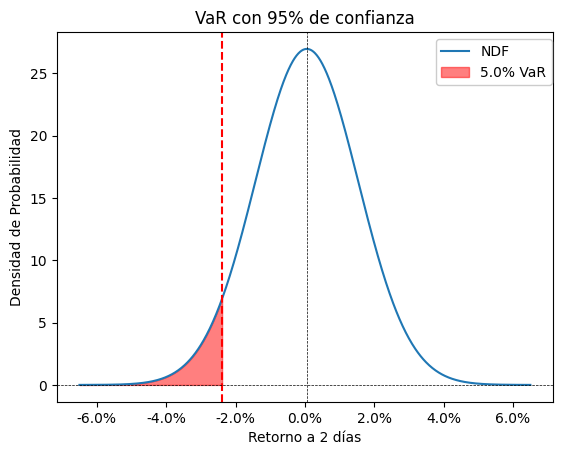

El VaR al 95.00% de confianza para un horizonte temporal de 2 días es: -2.38%


In [3]:
media_anualizada = 0.10
desvio_estandar_anualizado = 0.20
horizonte_temporal = 2
confianza = 0.95

media_diaria = media_anualizada / 365
desvio_estandar_diario = desvio_estandar_anualizado *np.sqrt(1/365)

z_score = norm.ppf(1 - (1 - confianza))
var_porcentual = (-z_score * desvio_estandar_diario * np.sqrt(horizonte_temporal)+media_diaria*horizonte_temporal)*100



def porcentaje_formatter(x, pos):
    return f'{x*100:.1f}%'

x = np.linspace(-0.065, 0.065, 1000)
pdf = norm.pdf(x, media_diaria * horizonte_temporal, desvio_estandar_diario * np.sqrt(horizonte_temporal))

fig, ax = plt.subplots()
ax.plot(x, pdf, label='NDF')
ax.fill_between(x[x <= var_porcentual/100], 0, pdf[x <= var_porcentual/100], color='red', alpha=0.5, label=f'{(1-confianza)*100:.1f}% VaR')

plt.xlabel('Retorno a 2 días')
plt.ylabel('Densidad de Probabilidad')
plt.title(f'VaR con {confianza*100:.0f}% de confianza')
plt.legend(loc='upper left', bbox_to_anchor=(0.75, 1), ncol=1, framealpha=1)

plt.axvline(var_porcentual/100, color='red', linestyle='--', label=f'VaR al {confianza*100:.2f}%')

formatter = FuncFormatter(porcentaje_formatter)
ax.xaxis.set_major_formatter(formatter)

ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.axvline(media_diaria * horizonte_temporal, color='black', linewidth=0.5, linestyle='--')

plt.show()

print(f'El VaR al {confianza*100:.2f}% de confianza para un horizonte temporal de {horizonte_temporal} días es: {var_porcentual:.2f}%')

In [4]:
z_score

1.6448536269514722

#VaR Normal

$P(R<=-0.0238)=$5%

$P(z<=\frac{[-0.0238-0.1*2/365]}{0.2*\sqrt{2/365}})=$5%

$\frac{[R^{*}-μ*T]}{σ*\sqrt{T}}=-α=\frac{[-0.0238-0.1*2/365]}{0.2*\sqrt{2/365}}=-1.64$

$R^{*}=μ*T-α*σ*\sqrt{T}=0.1*2/365-1.64*0.2*\sqrt{2/365}=-0.0238$

$VaR=(μ*T-α*σ*\sqrt{T})*W_0=(0.1*2/365-1.64*0.2*\sqrt{2/365})*10,000,000=-238,000$


In [5]:
fecha_inicial='1994-01-24' #YYYY-MM-DD
fecha_final='2024-09-24'

precios=yf.download(['SPY','M.BA','GGAL'],start=fecha_inicial,end=fecha_final,auto_adjust=True)

[*********************100%***********************]  3 of 3 completed


In [6]:
precios[['Retorno SPY','Retorno MERVAL']]=np.log(precios['Close'][['SPY','M.BA']]).diff() #Calculo el retorno logarítmico

precios=precios.dropna()

retornos_spy=precios['Retorno SPY']

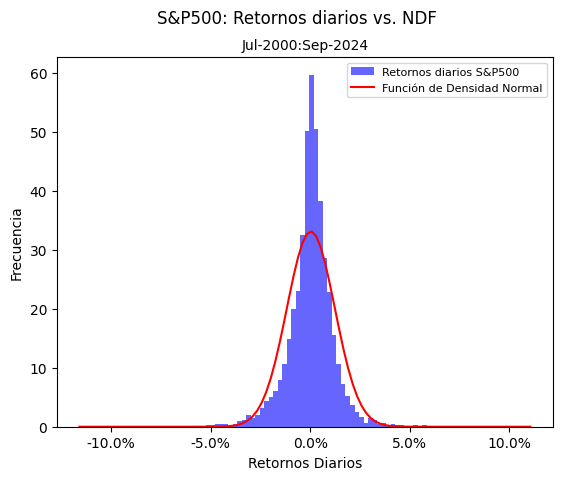

In [7]:
retornos_diarios = retornos_spy

fecha_inicio = retornos_diarios.index[0]
fecha_fin = retornos_diarios.index[-1]

media_diaria = np.mean(retornos_diarios)
desvio_estandar_diario = np.std(retornos_diarios)

plt.hist(retornos_diarios, bins=100, density=True, alpha=0.6, color='b', label='Retornos diarios S&P500')

x = np.linspace(min(retornos_diarios), max(retornos_diarios), 100)
pdf = (1 / (desvio_estandar_diario * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - media_diaria) / desvio_estandar_diario)**2)

plt.plot(x, pdf, color='r', label='Función de Densidad Normal')

titulo = f"{fecha_inicio.strftime('%b-%Y')}:{fecha_fin.strftime('%b-%Y')}"

plt.xlabel('Retornos Diarios')
plt.ylabel('Frecuencia')
plt.suptitle('S&P500: Retornos diarios vs. NDF',fontsize=12)
plt.title(titulo, ha='center',fontsize=10)
plt.legend(fontsize=8)

formatter = FuncFormatter(lambda y, _: '{:.1%}'.format(y))
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

In [8]:
media_diaria = np.mean(retornos_spy)
desvio_estandar_diario = np.std(retornos_spy)

probabilidad_normal_1_64=1-norm.cdf(1.64)
probabilidad_normal_1_96 = 1 - norm.cdf(1.96)
probabilidad_normal_2_32 = 1 - norm.cdf(2.32)
probabilidad_normal_3 = 1 - norm.cdf(3)

probabilidad_empirica_1_64=(retornos_spy<desvio_estandar_diario*-1.64+media_diaria).mean()
probabilidad_empirica_1_96 = (retornos_spy < desvio_estandar_diario * -1.96 + media_diaria).mean()
probabilidad_empirica_2_32 = (retornos_spy < desvio_estandar_diario * -2.32 + media_diaria).mean()
probabilidad_empirica_3 = (retornos_spy < desvio_estandar_diario * -3 + media_diaria).mean()

data = {
    'Dist. Normal': [probabilidad_normal_1_64,probabilidad_normal_1_96, probabilidad_normal_2_32, probabilidad_normal_3],
    'Dist. empírica': [probabilidad_empirica_1_64,probabilidad_empirica_1_96, probabilidad_empirica_2_32, probabilidad_empirica_3]
}
index = ['1.64 sigmas','1.96 sigmas', '2.32 sigmas', '3 sigmas']
tabla = pd.DataFrame(data, index=index)


tabla_estilizada = (tabla.style
                    .format("{:.4%}")
                    .set_table_styles([
                        {'selector': 'caption',
                         'props': [('font-weight', 'normal')]},  # Título sin negrita
                        {'selector': 'th',
                         'props': [('text-align', 'center'),
                                   ('border', '1px solid black')]},  # Bordes para los encabezados
                        {'selector': 'td',
                         'props': [('text-align', 'center'),
                                   ('border', '1px solid black')]},  # Bordes para las celdas
                        {'selector': 'tr > th:first-child',
                         'props': [('text-align', 'left'),
                                   ('border', '1px solid black')]}  # Bordes para el índice y alineación a la izquierda
                    ])
                    .set_caption("Probabilidad de observar retornos inferiores a:"))  # Título sin negrita

tabla_estilizada

,Dist. Normal,Dist. empírica
1.64 sigmas,5.0503%,4.7833%
1.96 sigmas,2.4998%,3.1326%
2.32 sigmas,1.0170%,2.0071%
3 sigmas,0.1350%,0.8629%


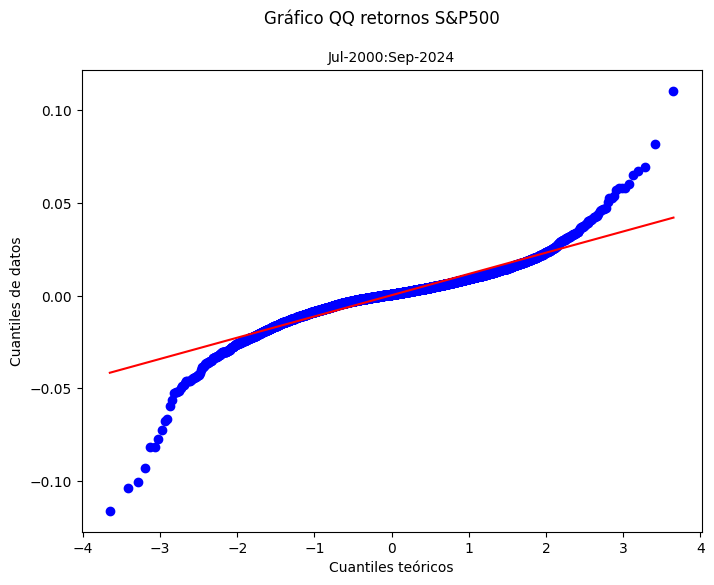

In [9]:
plt.figure(figsize=(8, 6))
stats.probplot(retornos_spy, dist="norm", plot=plt)
plt.suptitle('Gráfico QQ retornos S&P500',fontsize=12)
plt.xlabel("Cuantiles teóricos")
plt.ylabel("Cuantiles de datos")
plt.title(titulo,ha='center',fontsize=10)
plt.show()

In [10]:
datos = retornos_spy

jb_stat, jb_pvalor = jarque_bera(datos)

print(f'Estadístico de Jarque-Bera: {jb_stat}')
print(f'P-valor: {jb_pvalor}')

if jb_pvalor > 0.05:
    print('No se rechaza la hipótesis nula. Los datos pueden seguir una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos no siguen una distribución normal.')

Estadístico de Jarque-Bera: 22540.282253244393
P-valor: 0.0
Se rechaza la hipótesis nula. Los datos no siguen una distribución normal.


In [11]:
datos=retornos_spy

def log_likelihood(nu, data):
    n = len(data)
    sigma_sq = np.var(data, ddof=1)  # Estimación de la varianza muestral
    ll = -n/2 * np.log(np.pi) - (nu + 1)/2 * np.sum(np.log(1 + (1/nu) * (data**2/sigma_sq)))
    return -ll  # Devuelve el negativo del log-likelihood para minimizar

init_nu = 10

result = minimize(log_likelihood, init_nu, args=(datos,), method='BFGS')

nu_estimado = result.x[0]

print(f'Los grados de libertad estimados son: {nu_estimado}')

Los grados de libertad estimados son: 2.6118524526599454


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Resultados de Estimación

Los resultados obtenidos con el método MLE indican un ajuste razonable a la distribución t-Student.

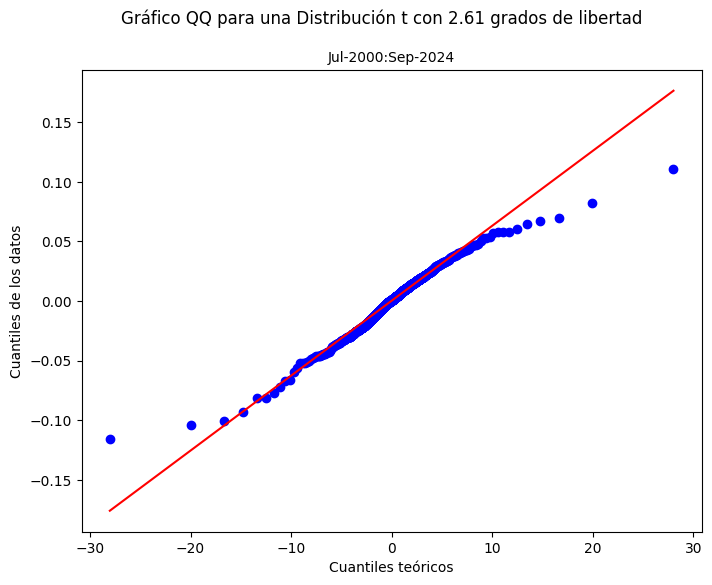

In [12]:
datos=retornos_spy

plt.figure(figsize=(8, 6))
probplot(datos, dist=t, sparams=(nu_estimado), plot=plt)

plt.suptitle(f'Gráfico QQ para una Distribución t con {nu_estimado:.2f} grados de libertad')
plt.xlabel("Cuantiles teóricos")
plt.ylabel("Cuantiles de los datos")
plt.title(titulo,ha='center',fontsize=10)
plt.show()

#VaR Lineal t de Student

 VaR Relativo: $VaR(t-Student)_{h,α,ν}=\sqrt{\frac{(ν-2)}{ν}*h}*t_{\nu,α}*σ-h*μ$

 VaR absoluto (zero VaR): $VaR(t-Student)_{h,α,ν}=\sqrt{\frac{(ν-2)}{ν}*h}*t_{\nu,α}$

Donde:


*   h: horizonte temporal en años
*   α: nivel de confianza
*   ν: grados de libertad
*   σ: volatilidad
*   $t_{\nu,α}:$ valor de *t* tal que $P(t<=t_{ν})=α$





In [13]:
returns_data = retornos_spy

alpha = 0.99 # Nivel de confianza (5%)
horizonte_temporal = 1  # Por ejemplo, 10 días

mu = np.mean(returns_data)
sigma = np.std(returns_data, ddof=1)  # Usar ddof=1 para desviación estándar muestral

Z_alpha = norm.ppf(1 - alpha)

VaR_normal = mu*horizonte_temporal + Z_alpha * sigma * np.sqrt(horizonte_temporal)

print(f'El VaR normal a {alpha * 100}% de confianza para un horizonte de {horizonte_temporal} días es: {VaR_normal:.4f}')

El VaR normal a 99.0% de confianza para un horizonte de 1 días es: -0.0277


In [14]:
returns_data = retornos_spy
alpha = 0.99  # Nivel de confianza (5%)
horizonte_temporal = 1  # Por ejemplo, 10 días
nu =nu_estimado  # Grados de libertad para la distribución t de Student

mu = np.mean(returns_data)
sigma = np.std(returns_data, ddof=1)  # Usar ddof=1 para desviación estándar muestral

t_alpha = t.ppf(1 - alpha, df=nu)

VaR_t = mu*horizonte_temporal + t_alpha * sigma * np.sqrt(((nu-2)/nu)) * np.sqrt(horizonte_temporal)

print(f'El VaR t de Student con {nu} grados de libertad a {alpha * 100}% de confianza para un horizonte de {horizonte_temporal} días es: {VaR_t:.4f}')


El VaR t de Student con 2.6118524526599454 grados de libertad a 99.0% de confianza para un horizonte de 1 días es: -0.0296


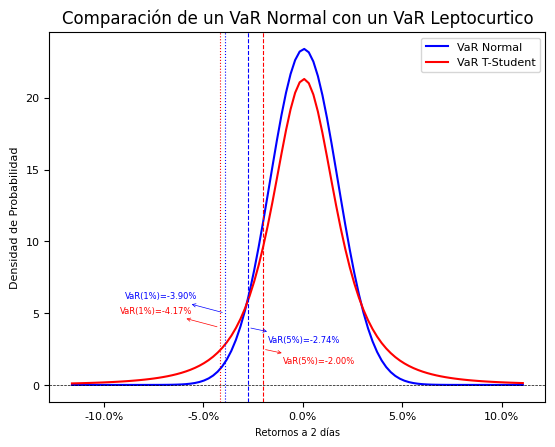

In [15]:
nu = nu_estimado  # Grados de libertad para la t de Student
alpha= 0.95 #nivel de confianza
alpha2=0.99
horizonte_temporal=2

retornos_diarios = retornos_spy

mu = np.mean(retornos_diarios)*horizonte_temporal
sigma = np.std(retornos_diarios)*np.sqrt(horizonte_temporal)

x = np.linspace(min(retornos_diarios), max(retornos_diarios), 100)


pdf_normal = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)
pdf_t = t.pdf(x, df=nu_estimado, loc=mu, scale=sigma)

Z_alpha = norm.ppf(1 - alpha)
Z_alpha2=norm.ppf(1-alpha2)

VaR_normal = mu + Z_alpha * sigma
VaR_normal2=mu+Z_alpha2*sigma

t_alpha = t.ppf(1 - alpha, df=nu)
t_alpha2=t.ppf(1-alpha2,df=nu)

VaR_t = mu + t_alpha * sigma * np.sqrt((nu-2)/nu)
VaR_t2=mu+t_alpha2*sigma*np.sqrt((nu-2)/nu)


def porcentaje_formatter(x, pos):
    return f'{x*100:.1f}%'

plt.plot(x, pdf_normal, label='Normal', color='blue')
plt.plot(x, pdf_t, label=f'T-Student (ν={nu:.2f})', color='red')

plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)

plt.axvline(VaR_normal, color='blue', linestyle='--',lw=0.8, label=f'VaR Normal ({alpha*100:.1f}%)')
plt.axvline(VaR_normal2,color='blue',linestyle='dotted',lw=0.8,label=f'Var Normal ({alpha2*100:0.1f}%)')
plt.axvline(VaR_t, color='red', linestyle='--',lw=0.8, label=f'VaR T-Student ({alpha*100:.0f}%)')
plt.axvline(VaR_t2,color='red',linestyle='dotted',lw=0.8,label=f'Var T-Student ({alpha2*100:0.1f}%)')


formatter = FuncFormatter(porcentaje_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

legend_text = ['VaR Normal',
               'VaR T-Student']



plt.annotate(f'VaR({(1-alpha)*100:0.0f}%)={VaR_normal*100:0.2f}%', xy=(VaR_normal, 4), xytext=(VaR_normal+0.01,3),
            arrowprops=dict(arrowstyle='<-',connectionstyle='arc3',lw=0.5,color='blue'), fontsize=6,color='blue',horizontalalignment='left')

plt.annotate(f'VaR({(1-alpha)*100:0.0f}%)={VaR_t*100:0.2f}%', xy=(VaR_t, 2.5), xytext=(VaR_t+0.01,1.5),
            arrowprops=dict(arrowstyle='<-',connectionstyle='arc3',lw=0.5,color='red'), fontsize=6,color='red')

plt.annotate(f'VaR({(1-alpha2)*100:0.0f}%)={VaR_normal2*100:0.2f}%', xy=(VaR_normal2, 5), xytext=(VaR_normal2-0.05,6),
            arrowprops=dict(arrowstyle='<-',connectionstyle='arc3',lw=0.5,color='blue'), fontsize=6,color='blue',horizontalalignment='left')

plt.annotate(f'VaR({(1-alpha2)*100:0.0f}%)={VaR_t2*100:0.2f}%', xy=(VaR_t2, 4), xytext=(VaR_t2-0.05,5),
            arrowprops=dict(arrowstyle='<-',connectionstyle='arc3',lw=0.5,color='red'), fontsize=6,color='red')


plt.xlabel(f'Retornos a {horizonte_temporal} días',fontsize=7)
plt.ylabel('Densidad de Probabilidad',fontsize=8)
plt.title('Comparación de un VaR Normal con un VaR Leptocurtico')
plt.legend(legend_text, loc='upper right', fontsize=8)

plt.show()

#VaR en función del nivel de confianza escogido

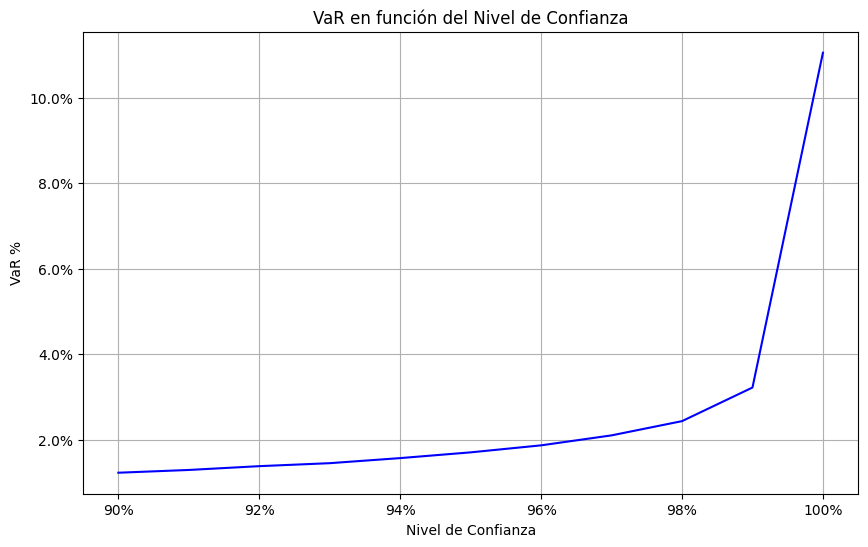

In [16]:
retornos = retornos_spy

niveles_confianza = np.arange(90, 101, 1)  # Desde 1% hasta 100%

var_percentil = np.percentile(retornos, niveles_confianza)

def porcentaje_y_formatter(x, pos):
    return f'{x*100:.1f}%'

def porcentaje_x_formatter(x, pos):
    return f'{x:.0f}%'

plt.figure(figsize=(10, 6))
plt.plot(niveles_confianza, var_percentil, color='blue')
plt.title('VaR en función del Nivel de Confianza')
plt.xlabel('Nivel de Confianza')
plt.ylabel('VaR %')
plt.gca().yaxis.set_major_formatter(FuncFormatter(porcentaje_y_formatter))
plt.gca().xaxis.set_major_formatter(FuncFormatter(porcentaje_x_formatter))
plt.grid(True)
plt.show()


#Cálculo del VaR Histórico

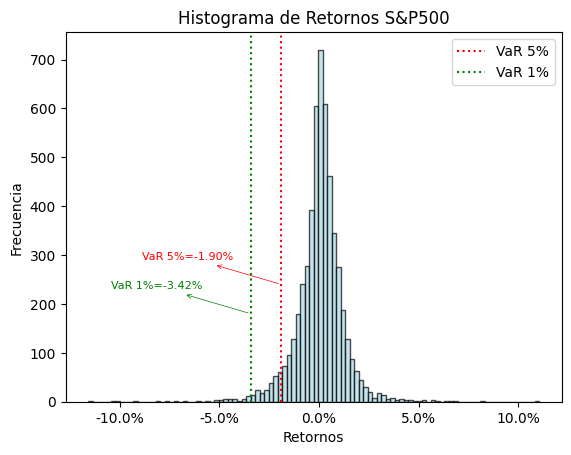

In [17]:
retornos = retornos_spy


alpha1=95
alpha2=99

var_1 = np.percentile(retornos, 100-alpha1)
var_2 = np.percentile(retornos, 100-alpha2)

plt.hist(retornos, bins=100, edgecolor='k', alpha=0.7, color='lightblue')

plt.axvline(x=var_1, color='red', linestyle='dotted', label=f'VaR {100-alpha1}%')
plt.axvline(x=var_2, color='green', linestyle='dotted', label=f'VaR {100-alpha2}%')


plt.annotate(f'VaR {100-alpha1}%={var_1*100:0.2f}%', xy=(var_1, 240), xytext=(var_1-0.07,290),
            arrowprops=dict(arrowstyle='<-',connectionstyle='arc3',lw=0.5,color='red'), fontsize=8,color='red',horizontalalignment='left')

plt.annotate(f'VaR {100-alpha2}%={var_2*100:0.2f}%', xy=(var_2, 180), xytext=(var_2-0.07,230),
            arrowprops=dict(arrowstyle='<-',connectionstyle='arc3',lw=0.5,color='green'), fontsize=8,color='green')

formatter = FuncFormatter(lambda y, _: '{:.1%}'.format(y))
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Retornos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Retornos S&P500')

plt.legend()

plt.show()

# Simulación Montecarlo

Aplicamos Montecarlo para generar caminos simulados y estimar el VaR.

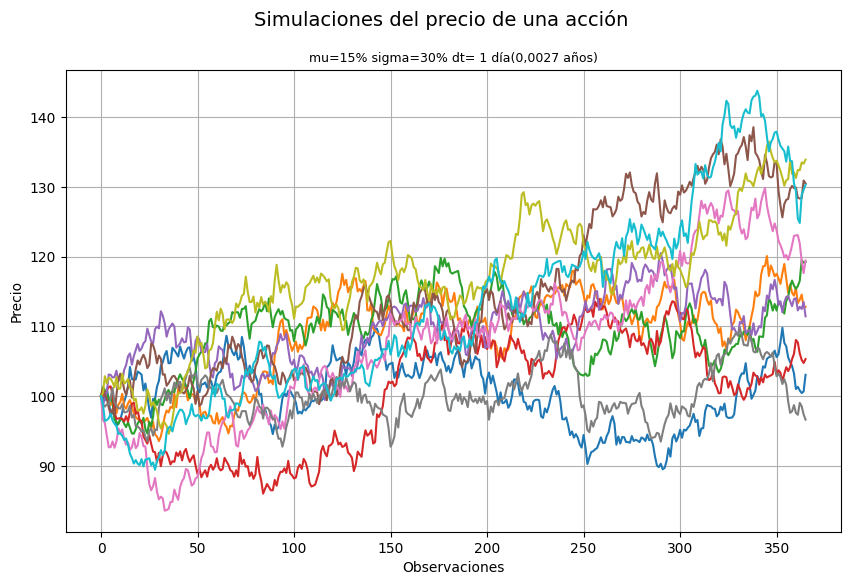

In [18]:
def gbm_simulation(S0, mu, sigma, T, N, n):
    """
    Realiza 'n' simulaciones de un proceso de Movimiento Browniano Geométrico (GBM).

    Args:
        S0 (float): Precio inicial.
        mu (float): Tasa de crecimiento esperada.
        sigma (float): Volatilidad.
        T (float): Horizonte de tiempo.
        N (int): Número de puntos de tiempo.
        n (int): Número de simulaciones.

    Returns:
        numpy.ndarray: Matriz de dimensiones (N+1, n) con los precios simulados.
    """
    dt = T / N
    t = np.linspace(0, T, N+1)
    S = np.zeros((N+1, n))
    S[0] = S0

    for i in range(1, N+1):
        z = np.random.standard_normal(n)
        S[i] = S[i-1] * np.exp(mu* dt + sigma * np.sqrt(dt) * z)

    return S

S0 = 100  # Precio inicial
mu = 0.15  # Tasa de crecimiento esperada; en un mundo neutral al riesgo mu=tasa libre de riesgo
sigma = 0.3  # Volatilidad
T = 0.5  # Horizonte de tiempo
N = 365  # Número de puntos de tiempo por año (por ejemplo, considerando días hábiles)
n = 10  # Número de simulaciones

simulated_prices = gbm_simulation(S0, mu, sigma, T, N, n)

plt.figure(figsize=(10, 6))
plt.plot(simulated_prices)
plt.suptitle('Simulaciones del precio de una acción',size=14)
plt.title('mu=15% sigma=30% dt= 1 día(0,0027 años)',size=9)
plt.xlabel('Observaciones')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

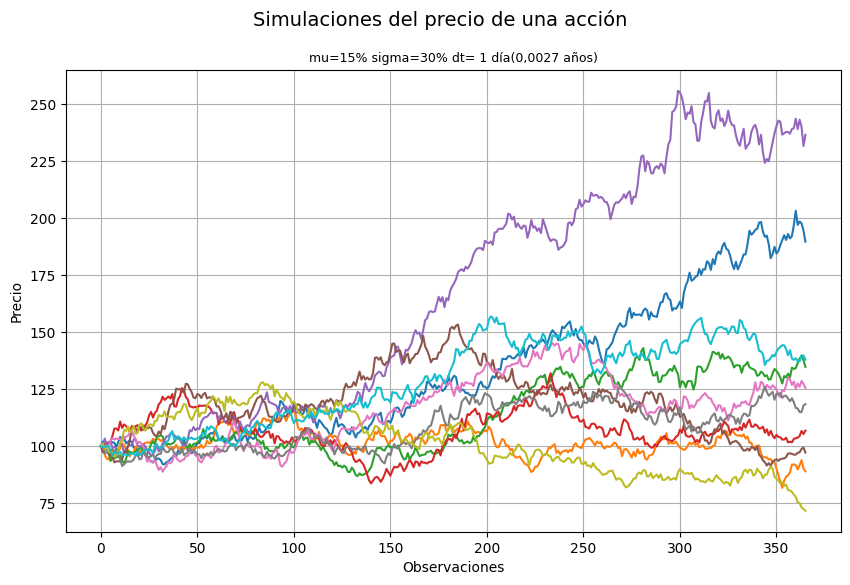

In [19]:
S0 = 100  # Precio inicial
mu = 0.15  # Tasa de crecimiento esperada; en un mundo neutral al riesgo mu=tasa libre de riesgo
sigma = 0.3  # Volatilidad
T = 1  # Horizonte de tiempo
N = 365  # Número de puntos de tiempo por año (por ejemplo, considerando días hábiles)
n = 10  # Número de simulaciones

def gbm_simulation(S0, mu, sigma, T, N, n):
    """
    Realiza 'n' simulaciones de un proceso de Movimiento Browniano Geométrico (GBM).

    Args:
        S0 (float): Precio inicial.
        mu (float): Tasa de crecimiento esperada.
        sigma (float): Volatilidad.
        T (float): Horizonte de tiempo.
        N (int): Número de puntos de tiempo.
        n (int): Número de simulaciones.

    Returns:
        numpy.ndarray: Matriz de dimensiones (N+1, n) con los precios simulados.
    """
    dt = T / N
    t = np.linspace(0, T, N+1)
    S = np.zeros((N+1, n))
    S[0] = S0

    for i in range(1, N+1):
        z = np.random.standard_normal(n)
        S[i] = S[i-1] * np.exp(mu* dt + sigma * np.sqrt(dt) * z)

    return S

simulated_prices = gbm_simulation(S0, mu, sigma, T, N, n)

plt.figure(figsize=(10, 6))
plt.plot(simulated_prices)
plt.suptitle('Simulaciones del precio de una acción',size=14)
plt.title('mu=15% sigma=30% dt= 1 día(0,0027 años)',size=9)
plt.xlabel('Observaciones')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

In [20]:
def var_t_student(mu, sigma, nu, alpha, h, N):

    rendimientos = np.random.standard_t(nu, size=(N, h)) * sigma + mu

    t_alpha = stats.t.ppf(1 - alpha, nu)
    var = mu * h - t_alpha * sigma * np.sqrt(h)


    var_escenarios = np.sum(rendimientos, axis=1) * h - t_alpha * sigma * np.sqrt(h)


    return var_escenarios

mu = np.mean(retornos_spy)  # Media del activo
sigma = np.std(retornos_spy)  # Desviación estándar del activo
nu = nu_estimado  # Grados de libertad para distribución t-Student
alpha1 = 0.01  # Nivel de significatividad (VaR al 95%)
alpha2=0.05
h = 1  # Horizonte de tiempo en días
N = 10000  # Número de escenarios

var_escenarios1 = var_t_student(mu, sigma, nu, alpha1, h, N)
var_escenarios2 = var_t_student(mu, sigma, nu,alpha2, h, N)


print(f"El VaR al {alpha1*100}% es: {np.percentile(var_escenarios1, alpha1*100)}")
print(f"El VaR al {alpha2*100}% es: {np.percentile(var_escenarios2, alpha2*100)}")

El VaR al 1.0% es: -0.12355918145636087
El VaR al 5.0% es: -0.06050152730566111


In [21]:
def var_normal(mu, sigma, alpha, h, N):

    rendimientos = np.random.normal(mu, sigma, (N, h))

    z_alpha = stats.norm.ppf(1 - alpha)
    var = mu * h - z_alpha * sigma * np.sqrt(h)

    var_escenarios = np.sum(rendimientos, axis=1) * h - z_alpha * sigma * np.sqrt(h)

    return var_escenarios

mu = np.mean(retornos_spy)  # Media del activo
sigma = np.std(retornos_spy)  # Desviación estándar del activo
alpha = 0.05  # Nivel de significatividad (VaR al 95%)
h = 1  # Horizonte de tiempo en días
N = 10000  # Número de escenarios

var_escenarios_normal = var_normal(mu, sigma, alpha, h, N)

print(f"El VaR promedio es: {np.mean(var_escenarios_normal)}")
print(f"El VaR al 95% es: {np.percentile(var_escenarios_normal, 5)}")

El VaR promedio es: -0.019725062452265556
El VaR al 95% es: -0.039041206803724075


#Backtesting

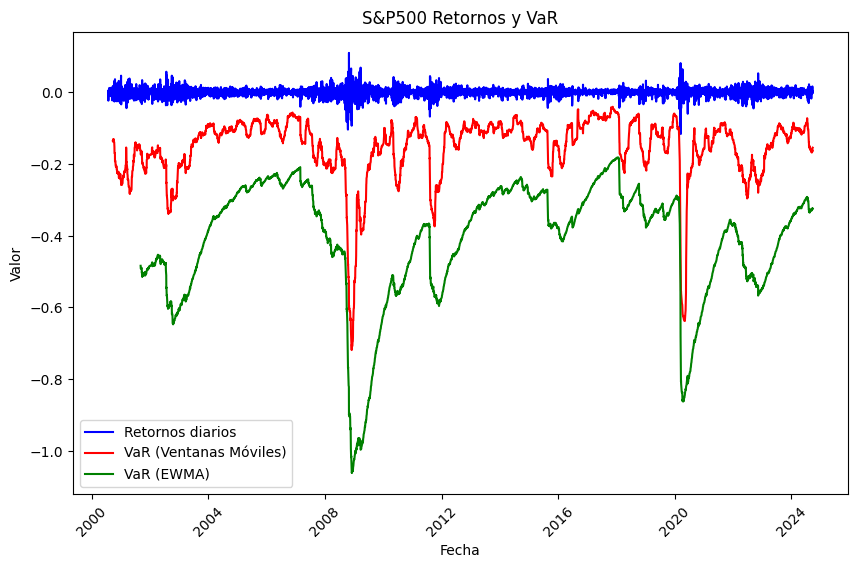

In [22]:
def calcular_var_rolling(returns, window_size=40, alpha=0.01):
    rolling_volatility = returns.rolling(window=window_size).std()
    return -norm.ppf(1-alpha) * rolling_volatility * np.sqrt(window_size)

def calcular_var_ewma(returns, lambda_=0.94, alpha=0.01):
    lambda_ = 1 - lambda_
    sigma = returns.ewm(span=252, min_periods=252).std()
    return -sigma * np.sqrt(252) * norm.ppf(1 - alpha)

var_rolling = calcular_var_rolling(retornos_spy)
var_ewma = calcular_var_ewma(retornos_spy)

plt.figure(figsize=(10, 6))

plt.plot(retornos_spy, label='Retornos diarios', color='blue')

plt.plot(var_rolling, label='VaR (Ventanas Móviles)', color='red')

plt.plot(var_ewma, label='VaR (EWMA)', color='green')

plt.title('S&P500 Retornos y VaR')
plt.xlabel('Fecha')
plt.ylabel('Valor')

plt.legend()

plt.xticks(rotation=45)

plt.show()




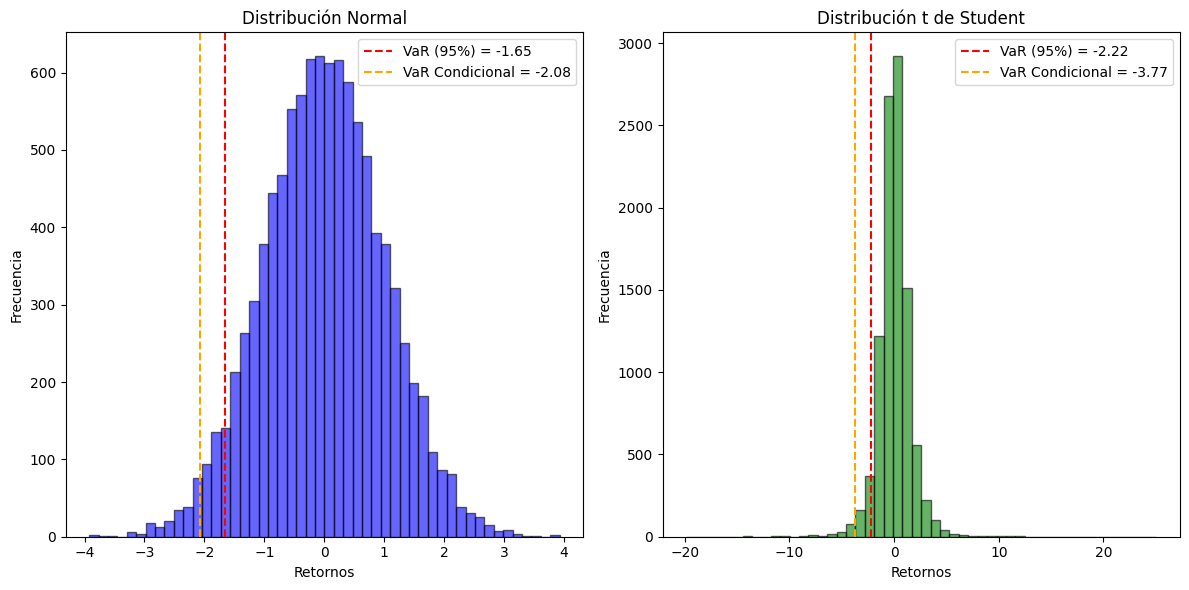

In [23]:
np.random.seed(42)
n = 10000  # Número de simulaciones
confidence_level = 0.95  # Nivel de confianza para VaR
alpha = 1 - confidence_level

normal_returns = np.random.normal(0, 1, n)  # Retornos normales
student_t_returns = np.random.standard_t(df=3, size=n)  # Retornos con colas gruesas

VaR_normal = np.percentile(normal_returns, alpha * 100)
VaR_student_t = np.percentile(student_t_returns, alpha * 100)

ES_normal = normal_returns[normal_returns < VaR_normal].mean()
ES_student_t = student_t_returns[student_t_returns < VaR_student_t].mean()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(normal_returns, bins=50, alpha=0.6, color='blue', edgecolor='black')
plt.axvline(x=VaR_normal, color='red', linestyle='--', label=f'VaR (95%) = {VaR_normal:.2f}')
plt.axvline(x=ES_normal, color='orange', linestyle='--', label=f'VaR Condicional = {ES_normal:.2f}')
plt.title('Distribución Normal')
plt.xlabel('Retornos')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(student_t_returns, bins=50, alpha=0.6, color='green', edgecolor='black')
plt.axvline(x=VaR_student_t, color='red', linestyle='--', label=f'VaR (95%) = {VaR_student_t:.2f}')
plt.axvline(x=ES_student_t, color='orange', linestyle='--', label=f'VaR Condicional = {ES_student_t:.2f}')
plt.title('Distribución t de Student')
plt.xlabel('Retornos')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()